# Distance-based treatment effects

Based on the figures from Holodinsky et al. 2017 - "Drip and Ship Versus Direct to Comprehensive Stroke Center"

## Notebook admin

In [1]:
# Import packages
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
from matplotlib.path    import Path
from matplotlib.patches import PathPatch

In [3]:
# Set up MatPlotLib
%matplotlib inline
# Change default colour scheme:
plt.style.use('seaborn-colorblind')

### Assumptions 

In [4]:
fixed_times = dict(
    onset_to_ambulance_arrival = 60,
    ivt_arrival_to_treatment   = 30,
    transfer_additional_delay  = 60,
    travel_ivt_to_mt           = 50,
    mt_arrival_to_treatment    = 90,
    )

---

# Define time grids.

For each point on a grid, find the travel time to a given coordinate (one of the treatment centres).

The treatment centres are located at the following coordinates:

+ IVT centre: (0, 0)
+ IVT/MT centre: (0, $-t_{\mathrm{travel}}^{\mathrm{IVT~to~MT}}$)

Change these parameters:

In [5]:
# Only calculate travel times up to this x and y displacement:
time_travel_max       = 80

# Change how granular the grid is. 
grid_step = 1 # minutes

# Make the grid a bit larger than the max travel time: 
grid_xy_max = time_travel_max + grid_step*2

Define a helper function to build the time grid:

In [6]:
def make_time_grid(xy_max, step, x_offset=0, y_offset=0):
    # Times for each row....
    x_times = np.arange(-xy_max, xy_max + step, step) - x_offset
    # ... and each column.
    y_times = np.copy(x_times) - y_offset
    # The offsets shift the position of (0,0) from the grid centre 
    # to (x_offset, y_offset). Distances will be calculated from the
    # latter point. 

    # Mesh to create new grids by stacking the rows (xx) 
    # and columns (yy):
    xx, yy = np.meshgrid(x_times, y_times)

    # Then combine the two temporary grids to find distances: 
    radial_times = np.sqrt(xx**2.0 + yy**2.0)
    return radial_times

Travel time directly to the IVT centre:

In [7]:
grid_time_travel_directly_to_ivt = make_time_grid(grid_xy_max, grid_step)

Travel time directly to the MT centre:

In [8]:
grid_time_travel_directly_to_mt = (
    make_time_grid(grid_xy_max, grid_step, 
                   y_offset=-fixed_times['travel_ivt_to_mt']) )

Difference in travel time:

In [9]:
grid_time_travel_directly_diff = (
    grid_time_travel_directly_to_ivt - grid_time_travel_directly_to_mt)

## Plot the grids

In [10]:
extent = [-grid_xy_max - grid_step*0.5, 
          +grid_xy_max - grid_step*0.5, 
          -grid_xy_max - grid_step*0.5, 
          +grid_xy_max - grid_step*0.5] 

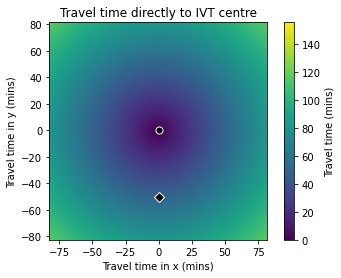

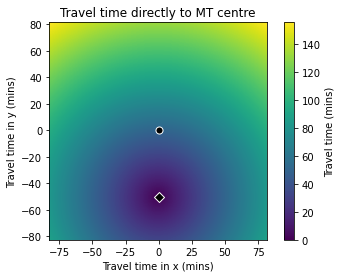

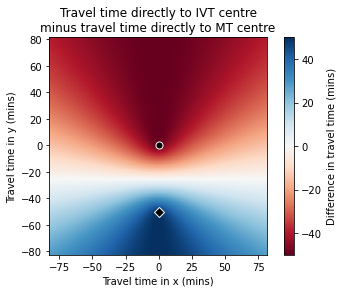

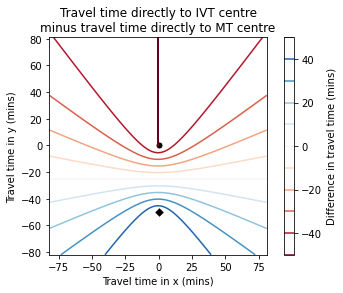

In [11]:
vmin = 0
vmax = np.max([grid_time_travel_directly_to_ivt,
               grid_time_travel_directly_to_mt])

for i in range(4):
    if i==0:
        # Travel directly to IVT centre
        plt.imshow(grid_time_travel_directly_to_ivt, origin='lower', 
                   extent=extent, vmin=vmin, vmax=vmax)
        plt.colorbar(label='Travel time (mins)')
        plt.title('Travel time directly to IVT centre')
        
    elif i==1:
        # Travel directly to IVT/MT centre
        plt.imshow(grid_time_travel_directly_to_mt, origin='lower', 
                   extent=extent, vmin=vmin, vmax=vmax)
        plt.colorbar(label='Travel time (mins)')
        plt.title('Travel time directly to MT centre')
        
    elif i==2:
        # Difference grid 
        plt.imshow(grid_time_travel_directly_diff, origin='lower', 
                   extent=extent, cmap='RdBu')
        plt.colorbar(label='Difference in travel time (mins)')
        plt.title('Travel time directly to IVT centre'+'\n'+
                  'minus travel time directly to MT centre')
        
    elif i==3:
        # Difference contours
        plt.contour(grid_time_travel_directly_diff, origin='lower', 
                    extent=extent,
                    levels=np.arange(-50,60,10), cmap='RdBu')
        plt.colorbar(label='Difference in travel time (mins)')
        plt.title('Travel time directly to IVT centre'+'\n'+
                  'minus travel time directly to MT centre')
                
    # Mark the treatment centre locations:
    plt.scatter(0,0, marker='o', color='k', edgecolor='w', s=50)
    plt.scatter(0,-fixed_times['travel_ivt_to_mt'], marker='D', 
                color='k', edgecolor='w', s=50)

    plt.xlabel('Travel time in x (mins)')
    plt.ylabel('Travel time in y (mins)')
    
    plt.gca().set_aspect('equal')
    plt.show()

There is a horizontal line halfway between the two treatment centres that marks where the travel times to the two treatment centres are equal. 

__Presumably these curves match the ones drawn in the Holodinsky et al. 2017 paper.__

---

# Travel time plot

Update plotting style:

In [12]:
time_step_circle = 5
circ_linewidth   = 0.5
grid_cmap        = 'viridis' 

Helper function to draw radiating circles from the IVT centre:

In [13]:
def make_coords_truncated_circle(time_travel, time_travel_ivt_to_mt, 
                                 trunc_val=None, n_coords=360):
    # Find the point halfway between the treatment centres:
    y_halfway = -0.5*time_travel_ivt_to_mt
    if trunc_val == None:
        trunc_val = y_halfway
    
    # Make a normal circle...
    angles_circle = np.linspace(0,2.0*np.pi,n_coords)
    x_circ = time_travel * np.sin(angles_circle)
    y_circ = time_travel * np.cos(angles_circle)
    # ... then cut it off at the halfway point between the treatment 
    # centres:
    y_circ[np.where(y_circ < y_halfway)] = trunc_val 

    return x_circ, y_circ

Helper function to find colour limits within the largest flattened radiating circle:

In [14]:
def find_mask_within_flattened_circle(grid_diff, grid_ivt, time_travel_max):
    """
    # Determine the min and max times in the area of the largest flattened
    # circle. 
    """
    # Make a copy of the grid that we'll delete invalid values from:
    grid_vals_uncovered = np.zeros_like(grid_diff)
    
    # Find values below the flat circle bottom:
    y_grid_halfway = np.where(grid_diff == np.nanmin(np.abs(grid_diff)))[0][0]
    
    # Find values outside the radius of the largest circle:
    coords_outside_max_time = np.where(grid_ivt > time_travel_max)
    
    # Remove unwanted values:
    grid_vals_uncovered[:y_grid_halfway]         = 1
    grid_vals_uncovered[coords_outside_max_time] = 1
    
    return grid_vals_uncovered

Gather the coordinates within the largest flattened radiating circle:

In [15]:
grid_mask = find_mask_within_flattened_circle(
    grid_time_travel_directly_diff, 
    grid_time_travel_directly_to_ivt, 
    time_travel_max)

coords_valid = np.where(grid_mask<1)

The main plot: 

In [16]:
def circle_plot(grid, travel_ivt_to_mt, time_travel_max, time_step_circle, 
                vmin, vmax, imshow=1, cmap='viridis', cbar_label='',
               cbar_format_str=None, n_contour_steps=5):
    fig, ax = plt.subplots(figsize=(10,8))

    # ----- Treatment centres ----- 
    # Mark the treatment centre locations:
    ax.scatter(0,0, marker='o', color='k', s=50, zorder=5)
    ax.scatter(0,-travel_ivt_to_mt, marker='D', color='k', s=50)
    # And draw a connecting line:
    ax.plot([0,0], [0,-travel_ivt_to_mt], color='k')


    # ----- Radiating circles ----- 
    # Define times for the radiating circles:
    circle_times = np.arange(
        time_step_circle, time_travel_max + time_step_circle, time_step_circle)

    # Define coordinates and plot the radiating circles:
    for travel_time in circle_times:
        if travel_time<time_travel_max:
            # Don't show the flat bottom line (gets thickened) 
            trunc_val = np.NaN
        else:
            # Show the flat bottom line 
            trunc_val = None
        # Define coordinates of the travel time circle.
        x_circ, y_circ = make_coords_truncated_circle(
            travel_time, travel_ivt_to_mt, trunc_val=trunc_val)

        if travel_time<time_travel_max:
            ax.plot(x_circ, y_circ, color='k', linewidth=circ_linewidth)
        else:
            # Make a patch using these coordinates. 
            # Use np.stack to get a series of ((x,y), (x,y), ... (x,y)) coords.
            circle_path  = Path(np.stack((x_circ,y_circ),axis=1))
            circle_patch = PathPatch(circle_path, 
                                     edgecolor='k', facecolor='None',
                                     linewidth = circ_linewidth)
            # Draw the patch:
            ax.add_patch(circle_patch)


    # ----- Grid of times ----- 
    if imshow>0:
        # Draw the grid as usual:
        imshow_grid = ax.imshow(grid, origin='lower', 
                                extent=extent, cmap=cmap,
                                vmin=vmin, vmax=vmax
                               )
        # Remove everything outside the biggest radiating circle:
        imshow_grid.set_clip_path(circle_patch)
        # Colourbar:
        cbar = plt.colorbar(imshow_grid, ax=ax, label=cbar_label)
    else:
        # Draw the grid as usual:
        contours = ax.contourf(grid, origin='lower', 
                               extent=extent, cmap=cmap, 
                               levels=np.linspace(vmin, vmax, n_contour_steps+1))
        # Remove everything outside the biggest radiating circle:
        for line in contours.collections:
            line.set_clip_path(circle_patch)
        # Colourbar:
        cbar = plt.colorbar(contours, ax=ax, label=cbar_label)

    if cbar_format_str != None:
        cbar.ax.set_yticklabels(
            [cbar_format_str.format(i) for i in cbar.get_ticks()]) 
        
        
    # ----- Other setup -----
    ax.set_aspect('equal')
    ax.set_xlim(-time_travel_max*1.1, time_travel_max*1.1)
    ax.set_ylim(-time_travel_max*1.1, time_travel_max*1.1)
    
    ax.set_xlabel('x co-ordinate (time from IVT-only unit, minutes)')
    ax.set_ylabel('y co-ordinate (time from IVT-only unit, minutes)')
    plt.show()


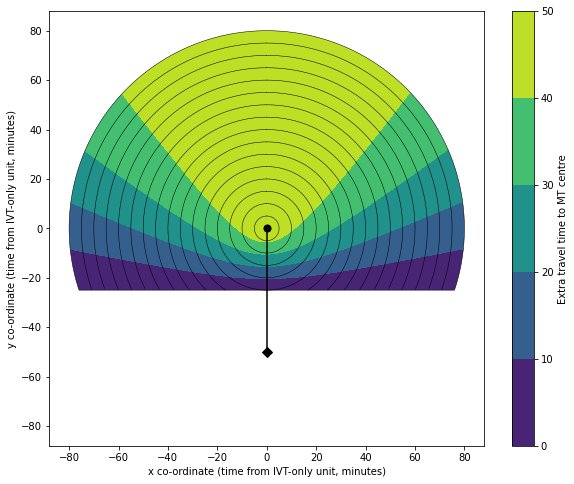

In [17]:
vmin = np.nanmin(-grid_time_travel_directly_diff[coords_valid])
vmax = np.nanmax(-grid_time_travel_directly_diff[coords_valid])

circle_plot(-grid_time_travel_directly_diff, fixed_times['travel_ivt_to_mt'], 
            time_travel_max, time_step_circle, vmin, vmax, imshow=0, 
            cbar_label='Extra travel time to MT centre')

# Convert time grid to utility grid

Print assumptions from earlier again: 

In [18]:
fixed_times

{'onset_to_ambulance_arrival': 60,
 'ivt_arrival_to_treatment': 30,
 'transfer_additional_delay': 60,
 'travel_ivt_to_mt': 50,
 'mt_arrival_to_treatment': 90}

Imports for the clinical outcome model:

In [19]:
from outcome_utilities.clinical_outcome import Clinical_outcome

In [20]:
import pandas as pd

In [21]:
mrs_dists = pd.read_csv(
    './outcome_utilities/mrs_dist_probs_cumsum.csv', index_col='Stroke type')

In [22]:
# Set up outcome model
outcome_model = Clinical_outcome(mrs_dists)

/home/anna/stroke_outcome/outcome_utilities/clinical_outcome.py:106: RuntimeWarning: divide by zero encountered in true_divide
  o = p / (1 - p)


## Patient population assumptions

Copied directly from the utility matrix notebook

In [23]:
prop_lvo = 0.35
prop_nlvo = 1 - prop_lvo
proportion_of_lvo_mt_also_receiving_IVT = 0.85

prop_lvo_treated_ivt_only = 0
prop_lvo_treated_ivt_mt = 0.286 # 0.286 gives 10% final MT if 35% LVO
prop_nlvo_treated_ivt_only = 0.155 # 0.155 gives final 20% IVT

treated_population = (
    prop_nlvo * prop_nlvo_treated_ivt_only +
    prop_lvo * prop_lvo_treated_ivt_mt +
    prop_lvo * prop_lvo_treated_ivt_only
    )

print ('Proportion all admissions treated: ', \
     f'{treated_population:0.3f}')
print ('Proportion LVO admissions treated with MT: ', \
    f'{prop_lvo_treated_ivt_mt:0.3f}')
print ('Proportion LVO admissions treated with IVT only: ' \
    f'{prop_lvo_treated_ivt_only:0.3f}')
print ('Proportion nLVO admissions treated with IVT: ' \
    f'{prop_nlvo_treated_ivt_only:0.3f}')
print ('Proportion LVO MT also receiving IVT: ' \
    f'{proportion_of_lvo_mt_also_receiving_IVT:0.3f}')

Proportion all admissions treated:  0.201
Proportion LVO admissions treated with MT:  0.286
Proportion LVO admissions treated with IVT only: 0.000
Proportion nLVO admissions treated with IVT: 0.155
Proportion LVO MT also receiving IVT: 0.850


## Grid of times to treatments:

Time to treatment at the IVT centre:

In [24]:
grid_time_treatment_ivt_at_ivtcentre = (
    fixed_times['onset_to_ambulance_arrival'] + 
    grid_time_travel_directly_to_ivt + 
    fixed_times['ivt_arrival_to_treatment']
    )

Time to treatment at the IVT/MT centre _following_ treatment at the IVT centre:

In [25]:
grid_time_treatment_ivt_at_ivt_then_mt_at_mtcentre = (
    fixed_times['onset_to_ambulance_arrival'] + 
    grid_time_travel_directly_to_ivt + 
    fixed_times['ivt_arrival_to_treatment'] + 
    fixed_times['transfer_additional_delay'] + 
    fixed_times['travel_ivt_to_mt'] + 
    fixed_times['mt_arrival_to_treatment']
    )

Time to treatment at the MT centre (_skipping_ transport to the IVT centre):

In [26]:
grid_time_treatment_ivt_at_mtcentre = (
    fixed_times['onset_to_ambulance_arrival'] + 
    grid_time_travel_directly_to_mt + 
    fixed_times['ivt_arrival_to_treatment']
    )

In [27]:
grid_time_treatment_ivt_then_mt_at_mtcentre = (
    fixed_times['onset_to_ambulance_arrival'] + 
    grid_time_travel_directly_to_mt + 
    fixed_times['ivt_arrival_to_treatment'] + 
    fixed_times['mt_arrival_to_treatment']
    )

__check the assumption of time between IVT and MT at the same centre above__

Method to find the added utility directly copied from the matrix notebook:

In [28]:
def find_grid_outcomes(
        grid_time_ivt, grid_time_mt, 
        prop_lvo, prop_nlvo, prop_lvo_treated_ivt_mt, 
        prop_lvo_treated_ivt_only, prop_nlvo_treated_ivt_only, 
        treated_population, proportion_of_lvo_mt_also_receiving_IVT):
    
    grid_shape = grid_time_treatment_ivt_at_ivtcentre.shape

    utility_grid = np.empty(grid_shape)
    mRS_grid     = np.empty(grid_shape)

    for row in range(grid_shape[0]):
        for col in range(int(grid_shape[1]*0.5)+1):
            time_to_ivt = grid_time_ivt[row, col]
            time_to_mt  = grid_time_mt[row, col]
            outcomes = outcome_model.calculate_outcomes(time_to_ivt, time_to_mt, patients=1000)

            # ----- Find added utility -----
            added_utility_lvo_ivt  = outcomes['lvo_ivt_added_utility']
            added_utility_lvo_mt   = outcomes['lvo_mt_added_utility']
            added_utility_nlvo_ivt = outcomes['nlvo_ivt_added_utility']

            # If LVO-IVT is greater utility than LVO-MT then adjust MT for 
            # proportion of patients receiving IVT
            if added_utility_lvo_ivt > added_utility_lvo_mt:
                diff = added_utility_lvo_ivt - added_utility_lvo_mt
                added_utility_lvo_mt += \
                    diff * proportion_of_lvo_mt_also_receiving_IVT

            added_utility = (
                (added_utility_lvo_mt   * prop_lvo  * prop_lvo_treated_ivt_mt) +
                (added_utility_lvo_ivt  * prop_lvo  * prop_lvo_treated_ivt_only) +
                (added_utility_nlvo_ivt * prop_nlvo * prop_nlvo_treated_ivt_only)
                            )
            utility_grid[row,col] = added_utility
            # Use symmetry to fill in the opposite column: 
            utility_grid[row,grid_shape[1]-1-col] = added_utility

            # ----- Find change in mRS -----
            reduced_mRS_lvo_ivt  = outcomes['lvo_ivt_mean_shift']
            reduced_mRS_lvo_mt   = outcomes['lvo_mt_mean_shift']
            reduced_mRS_nlvo_ivt = outcomes['nlvo_ivt_mean_shift']

            # If LVO-IVT is greater utility than LVO-MT then adjust MT for 
            # proportion of patients receiving IVT
            if reduced_mRS_lvo_ivt > reduced_mRS_lvo_mt:
                diff = reduced_mRS_lvo_ivt - reduced_mRS_lvo_mt
                reduced_mRS_lvo_mt += \
                    diff * proportion_of_lvo_mt_also_receiving_IVT

            reduced_mRS = (
                (reduced_mRS_lvo_mt   * prop_lvo  * prop_lvo_treated_ivt_mt) +
                (reduced_mRS_lvo_ivt  * prop_lvo  * prop_lvo_treated_ivt_only) +
                (reduced_mRS_nlvo_ivt * prop_nlvo * prop_nlvo_treated_ivt_only)
                            )
            mRS_grid[row,col] = reduced_mRS
            # Use symmetry to fill in the opposite column: 
            mRS_grid[row,grid_shape[1]-1-col] = reduced_mRS
            
    # Adjust outcome for just treated population
    utility_grid = utility_grid / treated_population
    mRS_grid     = mRS_grid     / treated_population
    return utility_grid, mRS_grid

__To do:__ reduce the copy-pasted code in the function above 

## Grids of changed outcomes

Case 1: IVT at the IVT centre, then MT at the IVT/MT centre

In [29]:
grid_utility_case1, grid_mRS_case1 = find_grid_outcomes(
    grid_time_treatment_ivt_at_ivtcentre, 
    grid_time_treatment_ivt_at_ivt_then_mt_at_mtcentre, 
    prop_lvo, prop_nlvo, prop_lvo_treated_ivt_mt, 
    prop_lvo_treated_ivt_only, prop_nlvo_treated_ivt_only, 
    treated_population,
    proportion_of_lvo_mt_also_receiving_IVT
    )

/home/anna/stroke_outcome/outcome_utilities/clinical_outcome.py:276: RuntimeWarning: invalid value encountered in true_divide
  treated_probs = treated_odds / (1 + treated_odds)
/home/anna/stroke_outcome/outcome_utilities/clinical_outcome.py:316: RuntimeWarning: invalid value encountered in true_divide
  treated_probs = treated_odds / (1 + treated_odds)
/home/anna/stroke_outcome/outcome_utilities/clinical_outcome.py:356: RuntimeWarning: invalid value encountered in true_divide
  treated_probs = treated_odds / (1 + treated_odds)


Case 2: IVT at the IVT/MT centre, then MT at the IVT/MT centre

In [30]:
grid_utility_case2, grid_mRS_case2 = find_grid_outcomes(
    grid_time_treatment_ivt_at_mtcentre, 
    grid_time_treatment_ivt_then_mt_at_mtcentre, 
    prop_lvo, prop_nlvo, prop_lvo_treated_ivt_mt, 
    prop_lvo_treated_ivt_only, prop_nlvo_treated_ivt_only, 
    treated_population,
    proportion_of_lvo_mt_also_receiving_IVT
    )

Difference between them:

In [31]:
grid_utility_diff = grid_utility_case2 - grid_utility_case1
grid_mRS_diff     = grid_mRS_case2     - grid_mRS_case1

## Plot the added utility grids

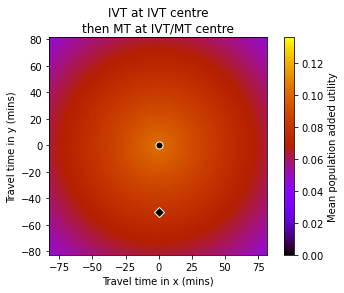

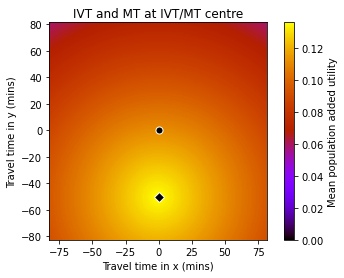

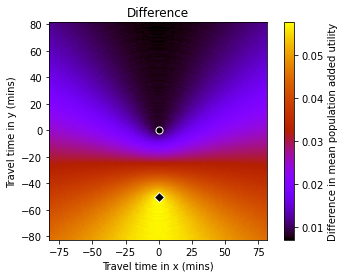

In [32]:
vmin = 0.0 #np.min([results_case1, results_case2])
vmax = np.max([grid_utility_case1, grid_utility_case2])

for i in range(3):
    if i==0:
        plt.imshow(grid_utility_case1, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax, cmap='gnuplot')
        plt.colorbar(label='Mean population added utility')
        plt.title('IVT at IVT centre'+'\n'+
                  'then MT at IVT/MT centre')
    elif i==1:
        plt.imshow(grid_utility_case2, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax, cmap='gnuplot')
        plt.colorbar(label='Mean population added utility')
        plt.title('IVT and MT at IVT/MT centre')
    elif i==2:
        plt.imshow(grid_utility_diff, origin='lower', 
                   extent=extent, cmap='gnuplot')
        plt.colorbar(label='Difference in mean population added utility')
        plt.title('Difference')

    # Mark the treatment centre locations:
    plt.scatter(0,0, marker='o', color='k', edgecolor='w', s=50)
    plt.scatter(0,-fixed_times['travel_ivt_to_mt'], marker='D', 
                color='k', edgecolor='w', s=50)

    plt.xlabel('Travel time in x (mins)')
    plt.ylabel('Travel time in y (mins)')

    plt.show()

Getting another horizontal line halfway between the two centres.

vmax 0.03308757281553397
vmax 0.035


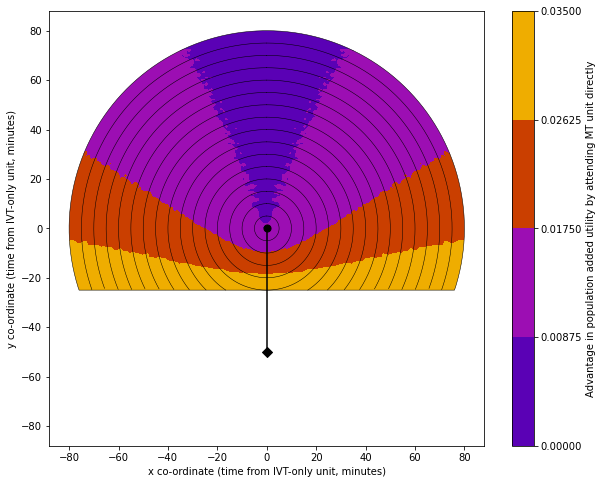

In [33]:
vmin = 0.0#np.nanmin(grid_utility_diff[coords_valid])
vmax = np.nanmax(grid_utility_diff[coords_valid])
print('vmax', vmax)
round_to_nearest = 0.005
vmax = np.ceil(vmax/round_to_nearest)*round_to_nearest
print('vmax', vmax)

circle_plot(grid_utility_diff, fixed_times['travel_ivt_to_mt'], 
            time_travel_max, time_step_circle, vmin, vmax, imshow=0, 
            cmap='gnuplot', 
            cbar_label=('Advantage in population added utility '+
                        'by attending MT unit directly'),
            n_contour_steps = 4, 
            # cbar_format_str='{:3.3f}'
           )

## Plot the reduced mRS grids

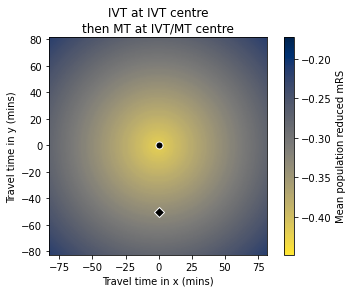

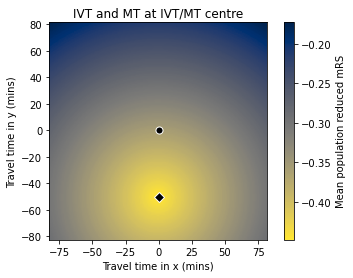

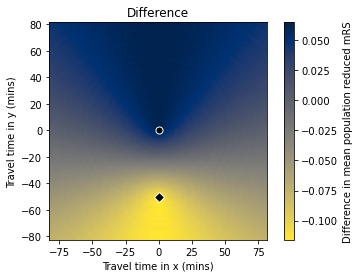

In [34]:
vmin = np.min([grid_mRS_case1, grid_mRS_case2])
vmax = np.max([grid_mRS_case1, grid_mRS_case2])

for i in range(3):
    if i==0:
        plt.imshow(grid_mRS_case1, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax, cmap='cividis_r')
        plt.colorbar(label='Mean population reduced mRS')
        plt.title('IVT at IVT centre'+'\n'+
                  'then MT at IVT/MT centre')
    elif i==1:
        plt.imshow(grid_mRS_case2, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax, cmap='cividis_r')
        plt.colorbar(label='Mean population reduced mRS')
        plt.title('IVT and MT at IVT/MT centre')
    elif i==2:
        plt.imshow(grid_mRS_diff, origin='lower', 
                   extent=extent, cmap='cividis_r')
        plt.colorbar(label='Difference in mean population reduced mRS')
        plt.title('Difference')

    # Mark the treatment centre locations:
    plt.scatter(0,0, marker='o', color='k', edgecolor='w', s=50)
    plt.scatter(0,-fixed_times['travel_ivt_to_mt'], marker='D', 
                color='k', edgecolor='w', s=50)

    plt.xlabel('Travel time in x (mins)')
    plt.ylabel('Travel time in y (mins)')

    plt.show()

Getting another horizontal line halfway between the two centres.

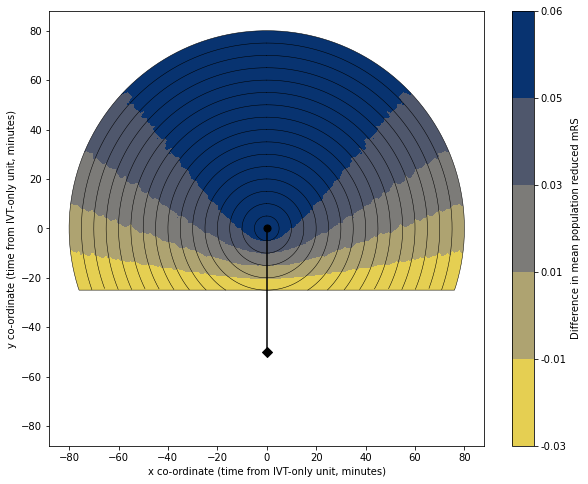

In [35]:
vmin = np.nanmin(grid_mRS_diff[coords_valid])
vmax = np.nanmax(grid_mRS_diff[coords_valid])

circle_plot(grid_mRS_diff, fixed_times['travel_ivt_to_mt'], 
            time_travel_max, time_step_circle, vmin, vmax, imshow=0, 
            cmap='cividis_r', 
            cbar_label='Difference in mean population reduced mRS',
            cbar_format_str='{:3.2f}'
    )